# 1. Get Data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)


# 2. Export from matlab and visualize

Dataset Shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor Labels: (3064,)
Unique Labels: [1 2 3]


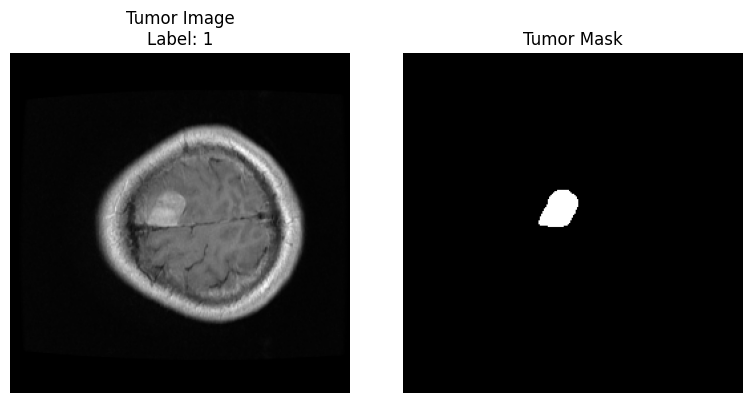

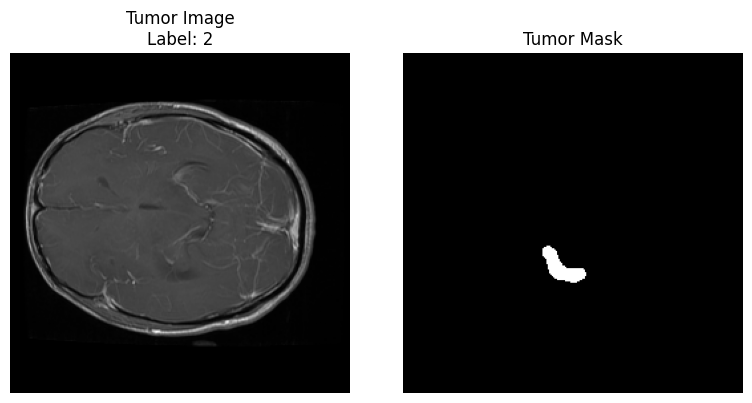

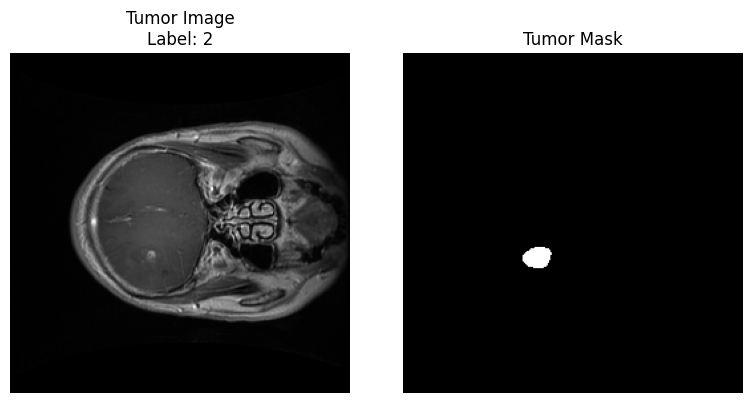

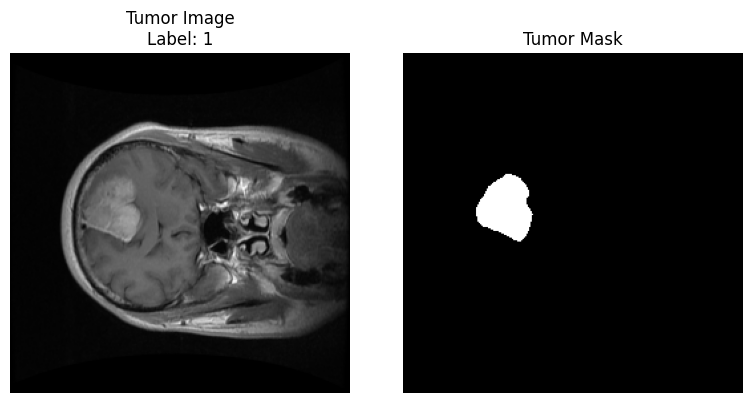

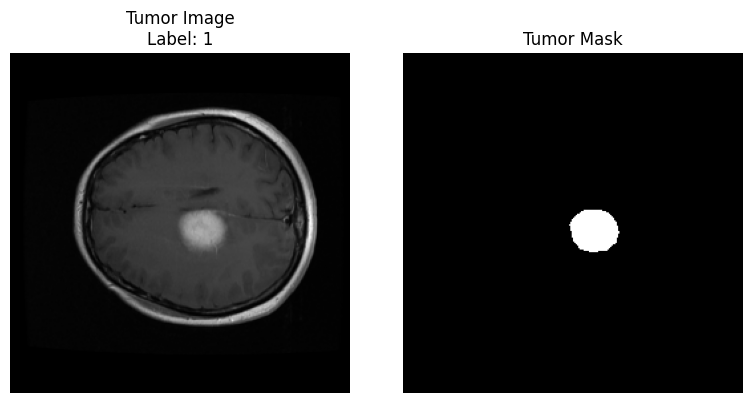

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data"
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # tumor image, resize and normalize for model input
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # Resize to 256x256 pixels
        image = image / 255.0  # Normalize pixel values to [0, 1]
        X_tumor.append(image)

        # tumor mask, resize and threshold into a binary image
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # Convert to binary mask
        Y_tumor_mask.append(mask)

        # tumor label (1: Meningioma, 2: Glioma, 3: Pituitary Tumor)
        label = int(np.array(data["cjdata"]["label"])[0][0])
        tumor_labels.append(label)

# lists to NumPy arrays
# add extra channel dimension (grayscale) for compatibility with most CNNs
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset Shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor Labels:", tumor_labels.shape)
print("Unique Labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocessing for Segmentation Only (for now)

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # Return image as is if dimensions match target
    if current_height == target_height and current_width == target_width:
        return image

    # Compute required padding
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)),
                              mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)),
                              mode='constant', constant_values=0)
    return padded_image

X_tumor_processed = []

for img in X_tumor:
    # If the image has more than one channel, convert it to grayscale.
    if img.ndim == 3 and img.shape[-1] != 1:
        # Convert image from normalized [0,1] range to [0,255] for cv2 conversion.
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # Normalize back to [0,1] and expand dims to add channel dimension.
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)


Processed X_tumor shape: (3064, 256, 256, 1)


# 4. Custom dataset, Lightning DataModule

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# Custom Dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        """
        images: numpy array of shape (N, 256, 256, 1)
        masks: numpy array of shape (N, 256, 256, 1)
        transform: optional transformations (e.g., augmentation)
        """
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Convert image and mask to torch tensors and squeeze the channel dimension if needed
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)  # from HWC to CHW
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)     # from HWC to CHW

        if self.transform:
            # Optionally, apply data augmentation here
            image, mask = self.transform(image, mask)

        return image, mask

# PyTorch Lightning DataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, batch_size=16, val_split=0.2, test_split=0.1, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Create the full dataset
        full_dataset = BrainTumorDataset(self.images, self.masks)
        dataset_size = len(full_dataset)

        # Determine split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # Randomly split the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

# Example usage:
batch_size = 16
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, batch_size=batch_size)
data_module.setup()  # Set up the splits

# Fetch one batch to verify
train_loader = data_module.train_dataloader()
for batch in train_loader:
    images, masks = batch
    print("Batch images shape:", images.shape)  # Expected: (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)      # Expected: (batch_size, 1, 256, 256)
    break


Train size: 2207, Val size: 551, Test size: 306
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])


# 5. Model, UNet Lightning

In [4]:
import torch.nn as nn
import torch.optim as optim


# Define a basic double convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, base_filters=64):
        super(UNet, self).__init__()
        self.in_conv = DoubleConv(n_channels, base_filters)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(base_filters, base_filters * 2)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(base_filters * 2, base_filters * 4)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(base_filters * 4, base_filters * 8)
        )
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(base_filters * 8, base_filters * 16)
        )
        self.up3 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(base_filters * 16, base_filters * 8)
        self.up2 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(base_filters * 8, base_filters * 4)
        self.up1 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(base_filters * 4, base_filters * 2)
        self.up0 = nn.ConvTranspose2d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.out_conv = nn.Conv2d(base_filters * 2, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.in_conv(x)          # Encoder Stage 1
        x2 = self.down1(x1)           # Encoder Stage 2
        x3 = self.down2(x2)           # Encoder Stage 3
        x4 = self.down3(x3)           # Encoder Stage 4
        x5 = self.bottleneck(x4)      # Bottleneck
        x4u = self.up3(x5)            # Decoder Stage 1
        x4u = torch.cat([x4u, x4], dim=1)
        x4c = self.conv3(x4u)
        x3u = self.up2(x4c)           # Decoder Stage 2
        x3u = torch.cat([x3u, x3], dim=1)
        x3c = self.conv2(x3u)
        x2u = self.up1(x3c)           # Decoder Stage 3
        x2u = torch.cat([x2u, x2], dim=1)
        x2c = self.conv1(x2u)
        x1u = self.up0(x2c)           # Decoder Stage 4
        x1u = torch.cat([x1u, x1], dim=1)
        out = self.out_conv(x1u)
        return torch.sigmoid(out)     # For binary segmentation, use sigmoid

# Define the PyTorch Lightning module for segmentation
class SegmentationModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(SegmentationModel, self).__init__()
        self.model = UNet(n_channels=1, n_classes=1)
        self.learning_rate = learning_rate
        self.loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.loss_fn(preds, masks)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)

        # Print training info every 10 batches
        if batch_idx % 10 == 0:
            print(f"[Train] Batch {batch_idx}, Loss: {loss.item():.4f}")
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        preds = self(images)
        loss = self.loss_fn(preds, masks)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)

        # Print validation info every 5 batches
        if batch_idx % 5 == 0:
            print(f"[Val] Batch {batch_idx}, Loss: {loss.item():.4f}")
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

# Example: instantiate the model
seg_model = SegmentationModel(learning_rate=1e-3)
print(seg_model)

SegmentationModel(
  (model): UNet(
    (in_conv): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (down1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU(inplace=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): ReLU(inplace=True)
        )
      )
    )
    (down2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding

# 6. Train

In [8]:
if torch.cuda.is_available():
    trainer = pl.Trainer(
        max_epochs=10,               # Set the desired number of epochs
        accelerator='gpu',           # Use GPU accelerator if available
        devices=1,                   # Use one GPU
        progress_bar_refresh_rate=20 # Optional refresh rate for the progress bar
    )
else:
    trainer = pl.Trainer(max_epochs=10)

# Start training using your previously created DataModule
trainer.fit(seg_model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | model   | UNet    | 30.9 M | train
1 | loss_fn | BCELoss | 0      | train
--------------------------------------------
30.9 M    Trainable params
0         Non-trainable params
30.9 M    Total params
123.680   Total estimated model params size (MB)
63        Modules in train mode
0         Modules in eval mode


Train size: 2207, Val size: 551, Test size: 306
Epoch 0:   0%|          | 0/138 [00:00<?, ?it/s]                           [Train] Batch 0, Loss: 1.3717



Detected KeyboardInterrupt, attempting graceful shutdown ...


Epoch 0:   2%|▏         | 3/138 [08:40<6:30:31,  0.01it/s, v_num=0, train_loss_step=0.290]


NameError: name 'exit' is not defined